In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [10]:
data = pd.read_csv('playlist.csv', index_col=1)
data = data[['track_popularity', 'discovery',
             'familiarity','hotttnesss','acousticness',
             'danceability','duration','energy','instrumentalness',
             'liveness','loudness','speechiness','tempo',
             'valence', 'love']]
data.head()

,track_popularity,discovery,familiarity,hotttnesss,acousticness,danceability,duration,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,love
track_name,,,,,,,,,,,,,,,
Guns Of Brixton,0.37,0.380807,0.679215,0.612283,0.241263,0.757744,0.279519,0.833648,3.528776e-06,0.095976,0.899546,0.030653,0.591532,0.899693,1
Orion,0.00,0.415065,0.629815,0.610436,0.879703,0.509577,0.591832,0.663268,8.546771e-01,0.098095,0.760369,0.037266,0.813985,0.634499,1
Tamacún,0.52,0.415065,0.629815,0.610436,0.814592,0.596223,0.263634,0.906601,8.238972e-01,0.100514,0.796230,0.034758,0.817285,0.970547,1
Don't Worry Baby - Mono,0.38,0.318312,0.821948,0.718851,0.334606,0.533372,0.216936,0.511184,4.105586e-09,0.063362,0.903111,0.029544,0.770432,0.800052,1
Heart in a Cage,0.39,0.416342,0.583200,0.566976,0.874616,0.505810,0.337113,0.433578,3.731721e-03,0.270910,0.648520,0.041427,0.878877,0.486386,1


In [229]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = data.drop('love',axis=1)
X = scaler.fit_transform(X)
Y = data['love']

from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.33, random_state=2)

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, auc

def measure(X, Y, clf, label_idx=1, n_folds=10):
    """label_idx stands for what we are calling positive in 
    precision recall testing"""
    kf = KFold(X.shape[0], n_folds=n_folds)
    
    results = dict(
        accuracy_scores = [],
        train_errors = [],
        test_errors = [],
        precisions = [],
        recalls = [],
        thresholds = [],
        aucs = []
    )
    
    for train, test in kf:
        X_train, Y_train = X[train], Y[train]
        X_test, Y_test = X[test], Y[test]

        clf.fit(X_train, Y_train)
        predicted = clf.predict(X_test)
        proba = clf.predict_proba(X_test)
        
        results['accuracy_scores'].append(clf.score(X_test, Y_test))
        results['train_errors'].append(1-clf.score(X_train, Y_train))
        results['test_errors'].append(1-clf.score(X_test, Y_test))

        precision, recall, pr_thresholds = precision_recall_curve(
             Y_test, proba[:, label_idx])
        results['precisions'].append(precision)
        results['recalls'].append(recall)
        results['thresholds'].append(pr_thresholds)
        results['aucs'].append(auc(recall, precision))
        
    results['train_errors'] = np.mean(results['train_errors'])
    results['test_errors'] = np.mean(results['test_errors'])        
    return results

##Analysis of Results

avg accuracy score 0.62380952381


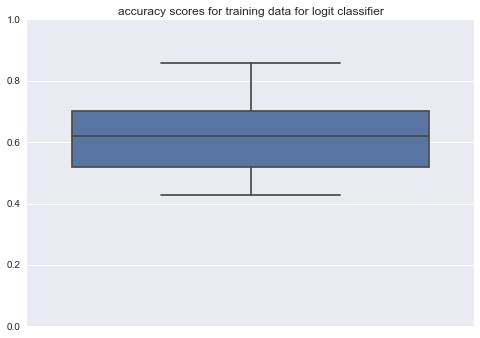

In [193]:
clf = LogisticRegression()
res = measure(X, Y, clf, label_idx=0)
plt.figure()
sns.boxplot(y=res['accuracy_scores'])
ax = plt.gca()
ax.set_ylim([0.0, 1.0])
ax.set_title('accuracy scores for training data for logit classifier')
print 'avg accuracy score', np.mean(res['accuracy_scores'])

Pretty bad accuracy.  Only slightly better than .5, which would be completely random.

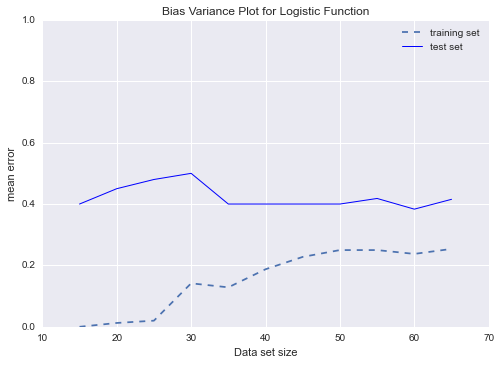

In [181]:
def bias_variance_curve(X, Y, clf):
    data_sizes = np.arange(15, len(X),5)
    train_errors = []
    test_errors = []

    for data_size in data_sizes:
        res = measure(X[:data_size], Y[:data_size], clf, n_folds=5)
        train_error, test_error = res['train_errors'], res['test_errors']
        train_errors.append(train_error)
        test_errors.append(test_error)
    plt.figure()
    plt.ylim([0.0, 1.0])
    plt.xlabel('Data set size')
    plt.ylabel('mean error')
    plt.title('Bias Variance Plot for Logistic Function')
    plt.plot(data_sizes, train_errors, '--', label='training set')
    plt.plot(data_sizes, test_errors, 'b-', lw=1, label='test set')
    plt.legend()
bias_variance_curve(X, Y, clf)


looks pretty freaking biased, because the test error is rapidly decreasing and the training error is slowly rising to greet it.  This indicates that we need new or better features.

It also has pretty high variance, because the curves maintain a big gap between them.

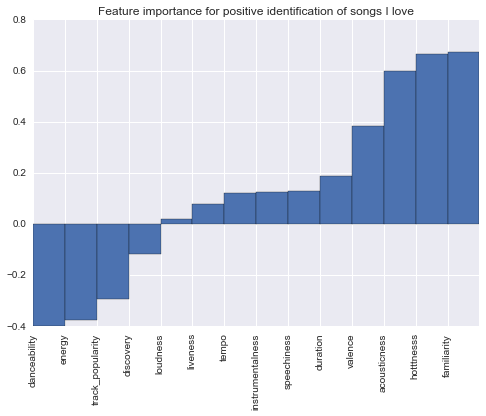

In [170]:
def plot_feature_importance(feature_names, coef_, name=''):
    plt.figure()

    coef = coef_.ravel()
    
    inds = np.argsort(coef)
    feature_names = feature_names[inds]
    coef = coef[inds]

    
    xpos = np.array(list(range(len(coef))))
    plt.bar(xpos, coef, width=1)

    plt.title('Feature importance for positive identification of songs I love')
    ax = plt.gca()
    ax.set_xticks(np.arange(len(coef)))
    labels = ax.set_xticklabels(feature_names)
    for label in labels:
        label.set_rotation(90)
    
clf2 = LogisticRegression()
clf2.fit(X_train, Y_train)
plot_feature_importance(data.columns, clf2.coef_)

In [236]:
from sklearn.metrics import classification_report
threshold = .7

test_passes_label = 1
Y_pred = clf.predict_proba(X_test)[:,test_passes_label]>threshold

print "Testing recognition of Love at high probability threshold"
print classification_report(Y_test, 
            Y_pred)

test_passes_label = 0
Y_pred = clf.predict_proba(X_test)[:,test_passes_label]<threshold
print "Testing recognition of justlike at probability threshold"
print classification_report(Y_test, 
            Y_pred)


Testing recognition of Love at high probability threshold
             precision    recall  f1-score   support

          0       0.33      0.75      0.46         4
          1       0.92      0.67      0.77        18

avg / total       0.82      0.68      0.72        22

Testing recognition of justlike at probability threshold
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.82      1.00      0.90        18

avg / total       0.67      0.82      0.74        22



With a high threshold for probability of loving a song though, my classifier does a very good job at classification.  However, it may be biased by the fact that I've got a lot more songs that I love than songs I just like.  As can be seen in the second report here, there was no song that my classifier could guess with 80% certainty that I would "just like".  

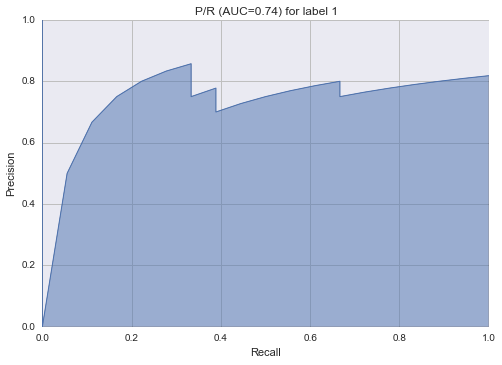

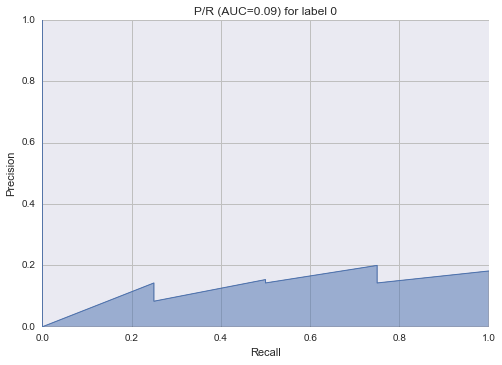

In [278]:
from sklearn.metrics import average_precision_score

def plot_precision_recall(y_true, probas_pred, scores, pos_label=1):
    probas_pred = probas_pred[:,pos_label]
    precision, recall, thresholds = precision_recall_curve(
            y_true, probas_pred, pos_label)
    aps = average_precision_score(y_true, probas_pred)
    aps = abs(1-pos_label-aps)
    plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R (AUC=%0.2f) for label %d' % (aps, pos_label))
    plt.fill_between(recall, precision, alpha=0.5)
    plt.grid(True, linestyle='-', color='0.75')
    plt.plot(recall, precision, lw=1)

clf3 = LogisticRegression()
clf3.fit(X_train, Y_train)
probas_pred = clf3.predict_proba(X_test)
scores = clf3.decision_function(X_test)
plot_precision_recall(Y_test, probas_pred, scores, 1)
plot_precision_recall(Y_test, probas_pred, scores, 0)

Notes:
* bigger sample size needed for songs that I don't like, I think.  I think the variance is high, but that it will be tamed with a larger data set, and the reason I think this is clear because every one of the metrics above just looks better when trained on the global X rather than the global training set.  The accuracy scores are higher and have a smaller standard deviation.  The bias variance plot is not stable or close to zero, but, how can I say, makes more sense with more data.  It looks clearly biased as opposed to just confusing